In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from scipy.optimize import linear_sum_assignment
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten, Conv2D, MaxPool2D,Conv2DTranspose,Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import itertools
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_test = [np.argmax(y)for y in y_test]
y_train = [np.argmax(y)for y in y_train]
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x_copy=np.zeros((10015,76,100,3))
for i in range(0,len(x)):
    x_temp=np.append(x[i],x[i][-1])
    x_temp=x_temp.reshape((76,100,3))
    x_copy[i]=x_temp.copy()
print(x_copy.shape)

(10015, 76, 100, 3)


In [3]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [4]:
def autoencoderConv2D(input_shape=(76, 100, 3), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'

    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[1]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[1]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [5]:
class ClusteringLayer(keras.layers.Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = keras.layers.InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = keras.layers.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
autoencoder, encoder = autoencoderConv2D()
autoencoder.load_weights('./conv_ae_weights.h5')
autoencoder.summary()
clustering_layer = ClusteringLayer(n_clusters=7, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 76, 100, 3)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 38, 50, 32)        2432      
_________________________________________________________________
conv2 (Conv2D)               (None, 19, 25, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 9, 12, 128)        73856     
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
embedding (Dense)            (None, 10)                138250    
_________________________________________________________________
dense (Dense)                (None, 13824)             152064   

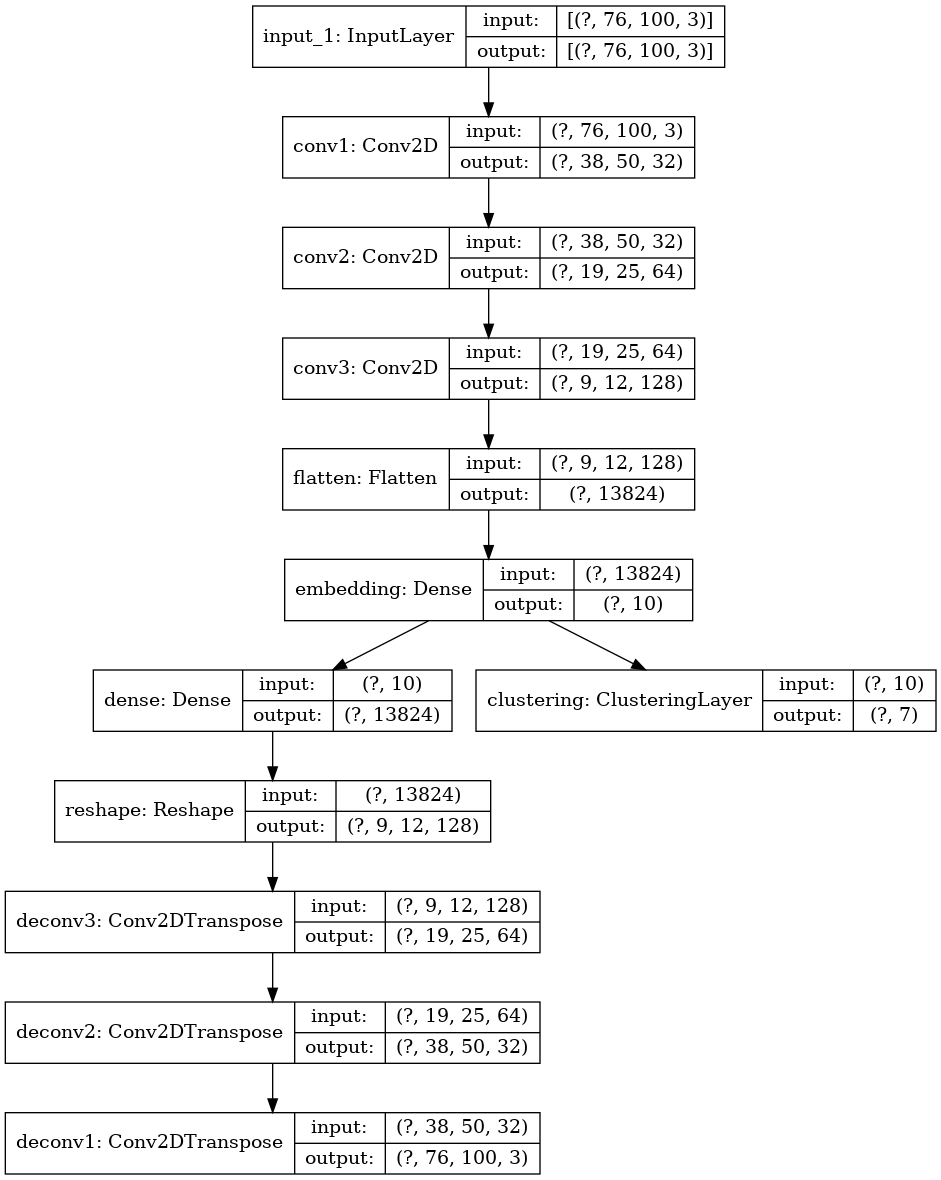

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [8]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1,1.5], optimizer= Adam(lr=0.008,decay=0.008/5000))

In [9]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [10]:
n_clusters=7
kmeans = KMeans(n_clusters=n_clusters)
y_pred = kmeans.fit_predict(encoder.predict(x_copy))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
loss = np.zeros(2)
index = 0
maxiter = 8000
batch_size = 1
update_interval = 100
index_array = np.arange(x_copy.shape[0])
tol = 0.001 # tolerance threshold to stop training
acc_array=np.zeros(67)
i=0
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q,m= model.predict(x_copy, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            accuracy = np.round(acc(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: accuracy = %.5f,' % (ite, accuracy), ' ; loss_kld=%f,loss_mse=%f '%(loss[0],loss[1]))
            acc_array[i]= accuracy
            i=i+1
        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if(ite > 0 and loss[1]<0.00001):
            model.compile(loss=['kld', 'mse'], loss_weights=[1,1], optimizer= SGD(0.01, 0.9))
        if (ite > 0 and delta_label < tol):
            if(delta_label < tol):
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_copy.shape[0])]
    loss = model.train_on_batch(x=x_copy[idx], y=[p[idx], x_copy[idx]])
    index = index + 1 if (index + 1) * batch_size <= x_copy.shape[0] else 0

model.save_weights('./conv_DEC_model_2_final.h5')

Iter 0: accuracy = 0.24863,  ; loss_kld=0.000000,loss_mse=0.000000 
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 100: accuracy = 0.29905,  ; loss_kld=2.259350,loss_mse=0.168210 
Iter 200: accuracy = 0.59261,  ; loss_kld=0.497150,loss_mse=0.005510 
Iter 300: accuracy = 0.28537,  ; loss_kld=0.962580,loss_mse=0.000070 
Iter 400: accuracy = 0.48927,  ; loss_kld=1.305190,loss_mse=0.054940 
Iter 500: accuracy = 0.27159,  ; loss_kld=0.566910,loss_mse=0.000840 
Iter 600: accuracy = 0.37933,  ; loss_kld=1.200390,loss_mse=0.011400 
Iter 700: accuracy = 0.35537,  ; loss_kld=0.620940,loss_mse=0.000070 
Iter 800: accuracy = 0.36515,  ; loss_kld=0.767730,loss_mse=0.000150 
Iter 900: accuracy = 0.43525,  ; loss_kld=1.453420,loss_mse=0.000100 
Iter 1000: accuracy = 0.63325,  ; loss_kld=0.339670,loss_mse=0.000570 
Iter 1100: accuracy = 0.66620,  ; loss_kld=0.408680,loss_mse=0.000000 
Iter 1200: accuracy = 0.66620,  ; loss_kld=0.364560,loss_mse=0.000

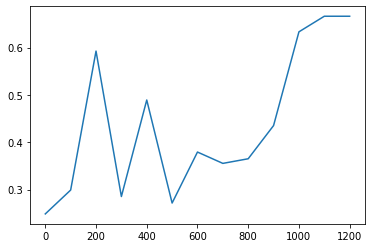

In [13]:
ite=np.linspace(0,1200,13)
plt.plot(ite,acc_array[0:13])
plt.show()

In [17]:
q ,m= model.predict(x_copy, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_value = np.round(acc(y, y_pred), 5)

    loss = np.round(loss[0], 5)
    print('Acc = %.5f' % (acc_value), ' ; loss=', loss)

Acc = 0.66620  ; loss= 0.36456


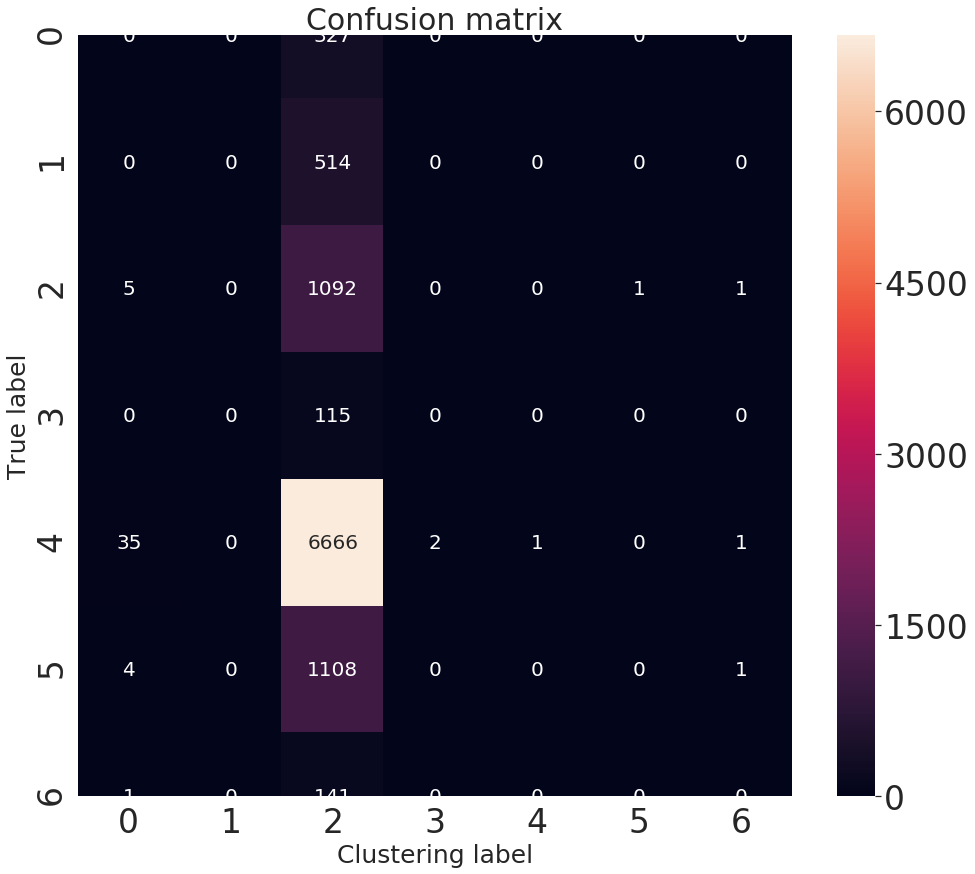

In [18]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()